# 权重衰减 weight decay

增大训练数据集可能会减轻过拟合，但是获取额外的训练数据往往代价高昂。本节介绍应对过拟合问题的常用方法：权重衰减

* 高维线性回归实验

生成样本及标签

In [199]:
import torch
import numpy as np

nTrain,nTest,nInput = 20,100,200

trueW,trueB=torch.ones(nInput,1,dtype=torch.float)*0.01,0.05

features = torch.randn(nTrain+nTest,nInput,dtype=torch.float)
labels=torch.mm(features,trueW)+trueB
labels+=torch.tensor(np.random.normal(0, 0.01, size=labels.shape),dtype=torch.float)
trainFeatures,testFeatures=features[0:nTrain,:],features[nTrain:,:]
trainLabels,testLabels=labels[0:nTrain,:],labels[nTrain:,:]

__从0实现__

初始化模型参数

In [200]:
w=torch.randn(nInput,1,requires_grad=True,dtype=torch.float)
b=torch.zeros(1,requires_grad=True,dtype=torch.float)

定义模型

In [201]:
def lineReg(x,w,b):
    return torch.mm(x,w)+b

定义损失函数

In [202]:
def squaredLoss(yP,y):
    return (yP-y.view(yP.size()))**2/2

定义L2范数惩罚项

In [203]:
def L2(w):
    return (w**2).sum()/2

定义小批量随机梯度下降法

In [204]:
def sgd(params,lr,batchSize):
    for param in params:
        param.data -= lr*param.grad / batchSize

作图函数

In [205]:
import matplotlib.pyplot as plt

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

训练

In [206]:
batchSize,numEpochs,lr=1,100,0.003
net,loss=lineReg,squaredLoss

dataset=torch.utils.data.TensorDataset(trainFeatures,trainLabels)
trainIter=torch.utils.data.DataLoader(dataset,batchSize,shuffle=True)

def fit(lambd):

    w=torch.randn(nInput,1,requires_grad=True,dtype=torch.float)
    b=torch.zeros(1,requires_grad=True,dtype=torch.float)

    trainLoss,testLoss=[],[]

    for epoch in range(numEpochs):
        for x,y in trainIter:
            yP=net(x,w,b)
            l=(loss(yP,y)+lambd*L2(w)).sum()
            l.backward()
            sgd([w,b],lr,batchSize)
            w.grad.data.zero_()
            b.grad.data.zero_()
        trainLoss.append(loss(net(trainFeatures,w,b),trainLabels).mean().item())
        testLoss.append(loss(net(testFeatures,w,b),testLabels).mean().item())
    semilogy(range(1,numEpochs+1),trainLoss,'epochs','loss',range(1,numEpochs+1),testLoss,['train','test'])
    print('L2 norm of w:',w.norm().item())

L2 norm of w: 13.001036643981934


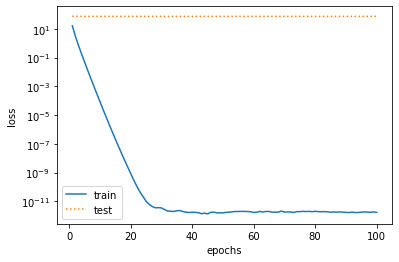

In [207]:
fit(0)

L2 norm of w: 0.038012973964214325


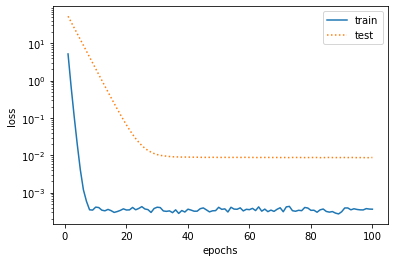

In [208]:
fit(3)

__简洁实现__

默认下，PyTorch会对权重和偏差同时衰减。我们可以分别对权重和偏差构造优化器实例，从而只对权重衰减。

In [209]:
import torch.nn as nn

def fitPytorch(wd):
    net=nn.Linear(nInput,1)
    nn.init.normal_(net.weight,mean=0,std=1)
    nn.init.normal_(net.bias,mean=0,std=1)
    optimizer_w=torch.optim.SGD([net.weight],lr=lr,weight_decay=wd)
    optimizer_b=torch.optim.SGD([net.bias],lr=lr)

    trainLoss,testLoss=[],[]

    for epoch in range(numEpochs):
        for x,y in trainIter:
            yP=net(x)
            l=loss(yP,y).mean()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
        trainLoss.append(loss(net(trainFeatures),trainLabels).mean().item())
        testLoss.append(loss(net(testFeatures),testLabels).mean().item())
    semilogy(range(1,numEpochs+1),trainLoss,'epochs','loss',range(1,numEpochs+1),testLoss,['train','test'])
    print('L2 norm of w:',net.weight.data.norm().item())


L2 norm of w: 14.30531120300293


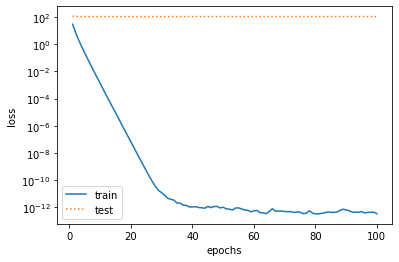

In [210]:
fitPytorch(0)

L2 norm of w: 0.043158721178770065


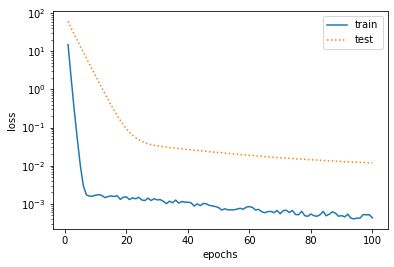

In [211]:
fitPytorch(3)